### Favorita 2016 data

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
from fastai.structured import *
from fastai.column_data import *
np.set_printoptions(threshold=50, edgeitems=20)
import datetime

PATH = 'data/favorita/'

In [3]:
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

from subprocess import check_output
print(check_output(["ls", PATH]).decode("utf8"))

# Any results you write to the current directory are saved as output.

holidays_events.csv
items.csv
models
oil.csv
raw_joined_10w16
raw_joined_test
raw_test
raw_train
sample_submission.csv
stores.csv
test.csv
tmp
train.csv
transactions.csv



## Create datasets

In [4]:
table_names = ['train', 'stores', 'items', 'transactions', 
               'holidays_events', 'oil', 'test', 'sample_submission']

We'll be using the popular data manipulation framework pandas. Among other things, pandas allows you to manipulate tables/data frames in python as one would in a database.

We're going to go ahead and load all of our csv's as dataframes into the list tables.

In [5]:
tables = [pd.read_csv(f'{PATH}{fname}.csv', low_memory=False) for fname in table_names]

In [6]:
from IPython.display import HTML

We can use `head()` to get a quick look at the contents of each table:
* **train**: includes the target unit_sales by date, store_nbr, and item_nbr and a unique id to label rows

* **stores**: metadata; including city, state, type, and cluster; cluster is a grouping of similar stores

* **items**: metadata; including family, class, and perishable; perishable have a score weight of 1.25; otherwise, the weight is 1.0

* **transactions**: count of sales transactions for each date, store_nbr combination. Only included for the training data timeframe

* **holidays_events**: metadata; Pay special attention to the transferred column.
    * A holiday that is transferred officially falls on that calendar day, but was moved to another date by the government. A transferred day is more like a normal day than a holiday. To find the day that it was actually celebrated, look for the corresponding row where type is Transfer.
    * For example, the holiday Independencia de Guayaquil was transferred from 2012-10-09 to 2012-10-12, which means it was celebrated on 2012-10-12. Days that are type Bridge are extra days that are added to a holiday (e.g., to extend the break across a long weekend). These are frequently made up by the type Work Day which is a day not normally scheduled for work (e.g., Saturday) that is meant to payback the Bridge.
    * Additional holidays are days added a regular calendar holiday, for example, as typically happens around Christmas (making Christmas Eve a holiday).

* **oil**: Daily oil price. Includes values during both the train and test data timeframe. (Ecuador is an oil-dependent country and it's economical health is highly vulnerable to shocks in oil prices.)

* **test**: Test data, with the date, store_nbr, item_nbr combinations that are to be predicted, along with the onpromotion information.
    * NOTE: The test data has a small number of items that are not contained in the training data. Part of the exercise will be to predict a new item sales based on similar products.
    * The public / private leaderboard split is based on time. All items in the public split are also included in the private split.
    
* **sample_submission**: sample submission file in the correct format. It is highly recommend you zip your submission file before uploading!

In [7]:
for t in tables: display(t.head(), t.shape)

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
0,0,2013-01-01,25,103665,7.0,NaN
1,1,2013-01-01,25,105574,1.0,NaN
2,2,2013-01-01,25,105575,2.0,NaN
3,3,2013-01-01,25,108079,1.0,NaN
4,4,2013-01-01,25,108701,1.0,NaN


(125497040, 6)

,store_nbr,city,state,type,cluster
0,1,Quito,Pichincha,D,13
1,2,Quito,Pichincha,D,13
2,3,Quito,Pichincha,D,8
3,4,Quito,Pichincha,D,9
4,5,Santo Domingo,Santo Domingo de los Tsachilas,D,4


(54, 5)

,item_nbr,family,class,perishable
0,96995,GROCERY I,1093,0
1,99197,GROCERY I,1067,0
2,103501,CLEANING,3008,0
3,103520,GROCERY I,1028,0
4,103665,BREAD/BAKERY,2712,1


(4100, 4)

,date,store_nbr,transactions
0,2013-01-01,25,770
1,2013-01-02,1,2111
2,2013-01-02,2,2358
3,2013-01-02,3,3487
4,2013-01-02,4,1922


(83488, 3)

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False


(350, 6)

,date,dcoilwtico
0,2013-01-01,NaN
1,2013-01-02,93.14
2,2013-01-03,92.97
3,2013-01-04,93.12
4,2013-01-07,93.20


(1218, 2)

,id,date,store_nbr,item_nbr,onpromotion
0,125497040,2017-08-16,1,96995,False
1,125497041,2017-08-16,1,99197,False
2,125497042,2017-08-16,1,103501,False
3,125497043,2017-08-16,1,103520,False
4,125497044,2017-08-16,1,103665,False


(3370464, 5)

,id,unit_sales
0,125497040,0
1,125497041,0
2,125497042,0
3,125497043,0
4,125497044,0


(3370464, 2)

In [8]:
# The following returns summarized aggregate information to each table accross each field.
for t in tables: display(DataFrameSummary(t).summary())

,id,date,store_nbr,item_nbr,unit_sales,onpromotion
count,1.25497e+08,NaN,1.25497e+08,1.25497e+08,1.25497e+08,NaN
mean,6.27485e+07,NaN,27.4646,972769,8.55487,NaN
std,3.62279e+07,NaN,16.3305,520534,23.6052,NaN
min,0,NaN,1,96995,-15372,NaN
25%,3.13743e+07,NaN,12,522383,2,NaN
50%,6.27485e+07,NaN,28,959500,4,NaN
75%,9.41228e+07,NaN,43,1.35438e+06,9,NaN
max,1.25497e+08,NaN,54,2.12711e+06,89440,NaN
counts,125497040,125497040,125497040,125497040,125497040,103839389
uniques,125497040,1684,54,4036,258474,2


,store_nbr,city,state,type,cluster
count,54,NaN,NaN,NaN,54
mean,27.5,NaN,NaN,NaN,8.48148
std,15.7321,NaN,NaN,NaN,4.69339
min,1,NaN,NaN,NaN,1
25%,14.25,NaN,NaN,NaN,4
50%,27.5,NaN,NaN,NaN,8.5
75%,40.75,NaN,NaN,NaN,13
max,54,NaN,NaN,NaN,17
counts,54,54,54,54,54
uniques,54,22,16,5,17


,item_nbr,family,class,perishable
count,4100,NaN,4100,4100
mean,1.25144e+06,NaN,2169.65,0.240488
std,587687,NaN,1484.91,0.427432
min,96995,NaN,1002,0
25%,818111,NaN,1068,0
50%,1.3062e+06,NaN,2004,0
75%,1.90492e+06,NaN,2990.5,0
max,2.13424e+06,NaN,7780,1
counts,4100,4100,4100,4100
uniques,4100,33,337,2


,date,store_nbr,transactions
count,NaN,83488,83488
mean,NaN,26.9392,1694.6
std,NaN,15.6082,963.287
min,NaN,1,5
25%,NaN,13,1046
50%,NaN,27,1393
75%,NaN,40,2079
max,NaN,54,8359
counts,83488,83488,83488
uniques,1682,54,4993


,date,type,locale,locale_name,description,transferred
count,350,350,350,350,350,350
unique,312,6,3,24,103,2
top,2014-06-25,Holiday,National,Ecuador,Carnaval,False
freq,4,221,174,174,10,338
counts,350,350,350,350,350,350
uniques,312,6,3,24,103,2
missing,0,0,0,0,0,0
missing_perc,0%,0%,0%,0%,0%,0%
types,categorical,categorical,categorical,categorical,categorical,bool


,date,dcoilwtico
count,NaN,1175
mean,NaN,67.7144
std,NaN,25.6305
min,NaN,26.19
25%,NaN,46.405
50%,NaN,53.19
75%,NaN,95.66
max,NaN,110.62
counts,1218,1175
uniques,1218,998


,id,date,store_nbr,item_nbr,onpromotion
count,3.37046e+06,NaN,3.37046e+06,3.37046e+06,NaN
mean,1.27182e+08,NaN,27.5,1.2448e+06,NaN
std,972969,NaN,15.5858,589836,NaN
min,1.25497e+08,NaN,1,96995,NaN
25%,1.2634e+08,NaN,14,805321,NaN
50%,1.27182e+08,NaN,27.5,1.29466e+06,NaN
75%,1.28025e+08,NaN,41,1.73002e+06,NaN
max,1.28868e+08,NaN,54,2.13424e+06,NaN
counts,3370464,3370464,3370464,3370464,3370464
uniques,3370464,16,54,3901,2


,id,unit_sales
count,3.37046e+06,3.37046e+06
mean,1.27182e+08,0
std,972969,0
min,1.25497e+08,0
25%,1.2634e+08,0
50%,1.27182e+08,0
75%,1.28025e+08,0
max,1.28868e+08,0
counts,3370464,3370464
uniques,3370464,1


In [9]:
train, stores, items, transactions, holidays_events, oil, test, sample_submission = tables

## Basic Data Cleaning, and redux data to 10 weeks in Summer 2016

### Train 

In [10]:
# replace the 17% of missing values in 'onpromotion' with False, as EDA suggested
%time
train.onpromotion.fillna(False, inplace = True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 7.87 µs


In [11]:
# Replace the strings 'True' and 'False' with actual booleans
train.onpromotion = train.onpromotion.map({'False' : False, 'True' : True})

In [12]:
# And convert it to an actual boolean type
train.onpromotion = train.onpromotion.astype(bool)

In [13]:
%time train.to_feather(f'{PATH}raw_train')

CPU times: user 10.5 s, sys: 7.4 s, total: 17.9 s
Wall time: 45.4 s


### Test

In [14]:
%%time
test.onpromotion.fillna(False, inplace = True)
test.onpromotion = test.onpromotion.map({'False' : False, 'True' : True})
test.onpromotion = test.onpromotion.astype(bool)
test.describe(include='all')

CPU times: user 1.25 s, sys: 0 ns, total: 1.25 s
Wall time: 1.25 s


In [15]:
%time test.to_feather(f'{PATH}raw_test')

CPU times: user 236 ms, sys: 180 ms, total: 416 ms
Wall time: 1.04 s


### Oil

In [16]:
# replace the 3.5% of missing values with '46.50'
%time
oil.dcoilwtico.fillna(46.50, inplace = True)

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.01 µs


#### Optimizing the Date format

The following extracts particular date fields from a complete datetime for the purpose of constructing categoricals.

You should *always* consider this feature extraction step when working with date-time. Without expanding your date-time into these additional fields, you can't capture any trend/cyclical behavior as a function of time at any of these granularities. We'll add to every table with a date field.

**note**: Dayofweek starts at 0, Dayofyear starts at 1

In [17]:
add_datepart(train, "date", drop=False)

In [18]:
add_datepart(transactions, "date", drop=False)

In [19]:
add_datepart(holidays_events, "date", drop=False)
add_datepart(oil, "date", drop=False)
add_datepart(test, "date", drop=False)

#### Reducing data to the last 10 weeks for the training set (16 days needed for Validation/Test)
Using 2016 data lets us use the same period 16-days, as the test data, but as validation period. 

In [20]:
# If done on all train data, results in 125m rows. So, we're taking a small sample of the 2016 10 weeks:
train_mask_10w = (train['date'] >= '2016-06-28') & (train['date'] <= '2016-08-31')
print(train.shape)

(125497040, 19)


In [21]:
train =  train[train_mask_10w]
print(train.shape)

(6270562, 19)


In [22]:
train.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
83386215,83386215,2016-06-28,1,103520,2.0,True,2016,6,26,28,1,180,False,False,False,False,False,False,1274
83386216,83386216,2016-06-28,1,103665,4.0,True,2016,6,26,28,1,180,False,False,False,False,False,False,1274
83386217,83386217,2016-06-28,1,105574,1.0,True,2016,6,26,28,1,180,False,False,False,False,False,False,1274
83386218,83386218,2016-06-28,1,105575,24.0,True,2016,6,26,28,1,180,False,False,False,False,False,False,1274
83386219,83386219,2016-06-28,1,105693,2.0,True,2016,6,26,28,1,180,False,False,False,False,False,False,1274


In [23]:
transactions_mask_10w = (transactions['date'] >= '2016-06-28') & (transactions['date'] <= '2016-08-31')
print(transactions.shape)

(83488, 16)


In [24]:
transactions =  transactions[transactions_mask_10w]
print(transactions.shape)

(3418, 16)


In [25]:
transactions.head()

,date,store_nbr,transactions,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
61715,2016-06-28,1,1699,2016,6,26,28,1,180,False,False,False,False,False,False,1274
61716,2016-06-28,2,1706,2016,6,26,28,1,180,False,False,False,False,False,False,1274
61717,2016-06-28,3,2688,2016,6,26,28,1,180,False,False,False,False,False,False,1274
61718,2016-06-28,4,1236,2016,6,26,28,1,180,False,False,False,False,False,False,1274
61719,2016-06-28,5,1156,2016,6,26,28,1,180,False,False,False,False,False,False,1274


In [26]:
holidays_events_mask_10w = (holidays_events['date'] >= '2016-06-28') & (holidays_events['date'] <= '2016-08-31')
print(holidays_events.shape)

(350, 19)


In [27]:
holidays_events =  holidays_events[holidays_events_mask_10w]
print(holidays_events.shape)

(11, 19)


In [28]:
holidays_events.head()

,date,type,locale,locale_name,description,transferred,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
261,2016-07-03,Holiday,Local,El Carmen,Cantonizacion de El Carmen,False,2016,7,26,3,6,185,False,False,False,False,False,False,1584
262,2016-07-03,Holiday,Local,Santo Domingo,Fundacion de Santo Domingo,False,2016,7,26,3,6,185,False,False,False,False,False,False,1584
263,2016-07-23,Holiday,Local,Cayambe,Cantonizacion de Cayambe,False,2016,7,29,23,5,205,False,False,False,False,False,False,1604
264,2016-07-24,Additional,Local,Guayaquil,Fundacion de Guayaquil-1,False,2016,7,29,24,6,206,False,False,False,False,False,False,1605
265,2016-07-24,Transfer,Local,Guayaquil,Traslado Fundacion de Guayaquil,False,2016,7,29,24,6,206,False,False,False,False,False,False,1605


In [29]:
oil_mask_10w = (oil['date'] >= '2016-06-28') & (oil['date'] <= '2016-08-31')
print(oil.shape)

(1218, 15)


In [30]:
oil =  oil[oil_mask_10w]
print(oil.shape)

(47, 15)


In [31]:
oil.head()

,date,dcoilwtico,Year,Month,Week,Day,Dayofweek,Dayofyear,Is_month_end,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed
910,2016-06-28,47.93,2016,6,26,28,1,180,False,False,False,False,False,False,1274
911,2016-06-29,49.85,2016,6,26,29,2,181,False,False,False,False,False,False,1275
912,2016-06-30,48.27,2016,6,26,30,3,182,True,False,True,False,False,False,1276
913,2016-07-01,49.02,2016,7,26,1,4,183,False,True,False,True,False,False,1277
914,2016-07-04,46.50,2016,7,27,4,0,186,False,False,False,False,False,False,1280


## Feature Engineering

As a structured data problem, we necessarily have to go through all the cleaning and feature engineering, even though we're using a neural network.

`join_df` is a function for joining tables on specific fields. By default, we'll be doing a left outer join of `right` on the `left` argument using the given fields for each table.

Pandas does joins using the `merge` method. The `suffixes` argument describes the naming convention for duplicate fields. We've elected to leave the duplicate field names on the left untouched, and append a "\_y" to those on the right.

In [32]:
def join_df(left, right, left_on, right_on=None, suffix='_y'):
    if right_on is None: right_on = left_on
    return left.merge(right, how='left', left_on=left_on, right_on=right_on, 
                      suffixes=("", suffix))

Join df_train/stores

In [33]:
joined = join_df(train, stores, "store_nbr")

In [34]:
joined.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,...,Is_month_start,Is_quarter_end,Is_quarter_start,Is_year_end,Is_year_start,Elapsed,city,state,type,cluster
0,83386215,2016-06-28,1,103520,2.0,True,2016,6,26,28,...,False,False,False,False,False,1274,Quito,Pichincha,D,13
1,83386216,2016-06-28,1,103665,4.0,True,2016,6,26,28,...,False,False,False,False,False,1274,Quito,Pichincha,D,13
2,83386217,2016-06-28,1,105574,1.0,True,2016,6,26,28,...,False,False,False,False,False,1274,Quito,Pichincha,D,13
3,83386218,2016-06-28,1,105575,24.0,True,2016,6,26,28,...,False,False,False,False,False,1274,Quito,Pichincha,D,13
4,83386219,2016-06-28,1,105693,2.0,True,2016,6,26,28,...,False,False,False,False,False,1274,Quito,Pichincha,D,13


In [35]:
joined_test = join_df(test, stores, "store_nbr")
len(joined_test[joined_test.type.isnull()])

0

In [36]:
joined = join_df(joined, items, "item_nbr")

In [37]:
joined.head()

,id,date,store_nbr,item_nbr,unit_sales,onpromotion,Year,Month,Week,Day,...,Is_year_end,Is_year_start,Elapsed,city,state,type,cluster,family,class,perishable
0,83386215,2016-06-28,1,103520,2.0,True,2016,6,26,28,...,False,False,1274,Quito,Pichincha,D,13,GROCERY I,1028,0
1,83386216,2016-06-28,1,103665,4.0,True,2016,6,26,28,...,False,False,1274,Quito,Pichincha,D,13,BREAD/BAKERY,2712,1
2,83386217,2016-06-28,1,105574,1.0,True,2016,6,26,28,...,False,False,1274,Quito,Pichincha,D,13,GROCERY I,1045,0
3,83386218,2016-06-28,1,105575,24.0,True,2016,6,26,28,...,False,False,1274,Quito,Pichincha,D,13,GROCERY I,1045,0
4,83386219,2016-06-28,1,105693,2.0,True,2016,6,26,28,...,False,False,1274,Quito,Pichincha,D,13,GROCERY I,1034,0


In [38]:
joined_test = join_df(joined_test, items, "item_nbr")
len(joined_test[joined_test.family.isnull()])

0

In [39]:
joined = join_df(joined, transactions, ['date', 'store_nbr'])

In [40]:
joined.head().T.head(40)

,0,1,2,3,4
id,83386215,83386216,83386217,83386218,83386219
date,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00
store_nbr,1,1,1,1,1
item_nbr,103520,103665,105574,105575,105693
unit_sales,2,4,1,24,2
onpromotion,True,True,True,True,True
Year,2016,2016,2016,2016,2016
Month,6,6,6,6,6
Week,26,26,26,26,26
Day,28,28,28,28,28


In [41]:
joined_test = join_df(joined_test, transactions, ["date", "store_nbr"] )
len(joined_test[joined_test.store_nbr.isnull()])

0

**Note: in this basic model, we don't incorporate the Holidays (needs tuning for local vs national) or the Oil prices, this will also require external data sources on the Test set.**


**TBD**

In [42]:
# we drop the duplicate columns ending with _y
for df in (joined, joined_test):
    for c in df.columns:
        if c.endswith('_y'):
            if c in df.columns: df.drop(c, inplace=True, axis=1)

In [43]:
joined.head().T.head(40)

,0,1,2,3,4
id,83386215,83386216,83386217,83386218,83386219
date,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00,2016-06-28 00:00:00
store_nbr,1,1,1,1,1
item_nbr,103520,103665,105574,105575,105693
unit_sales,2,4,1,24,2
onpromotion,True,True,True,True,True
Year,2016,2016,2016,2016,2016
Month,6,6,6,6,6
Week,26,26,26,26,26
Day,28,28,28,28,28


Let's save this with feather

In [44]:
%time joined.to_feather(f'{PATH}raw_joined_10w16')

CPU times: user 2.12 s, sys: 1.31 s, total: 3.43 s
Wall time: 8.27 s


In [45]:
%time joined_test.to_feather(f'{PATH}raw_joined_test')

CPU times: user 1.1 s, sys: 712 ms, total: 1.81 s
Wall time: 4.29 s


## Create features

In [ ]:
joined = pd.read_feather(f'{PATH}raw_joined_10w16', nthreads=16)

In [ ]:
joined_test = pd.read_feather(f'{PATH}raw_joined_test', nthreads=16)

In [46]:
cat_vars = ['store_nbr', 'item_nbr', 'onpromotion', 'Year', 'Month', 'Week', 'Day', 'Dayofweek', 'Dayofyear',
            'city', 'state', 'type', 'cluster', 'family', 'class', 'perishable']

In [47]:
contin_vars = ['transactions', 'Elapsed']

In [48]:
for v in cat_vars:
    joined[v] = joined[v].astype('category').cat.as_ordered()

In [49]:
for v in contin_vars:
    joined[v] = joined[v].astype('float32')

In [50]:
for v in cat_vars:
    joined_test[v] = joined_test[v].astype('category').cat.as_ordered()

In [51]:
dep = 'unit_sales'
joined = joined[cat_vars+contin_vars+[dep]].copy()

In [52]:
joined_test[dep] = 0
joined_test = joined_test[cat_vars+contin_vars+[dep, 'id']].copy()

In [53]:
joined.head().T.head(40)

,0,1,2,3,4
store_nbr,1,1,1,1,1
item_nbr,103520,103665,105574,105575,105693
onpromotion,True,True,True,True,True
Year,2016,2016,2016,2016,2016
Month,6,6,6,6,6
Week,26,26,26,26,26
Day,28,28,28,28,28
Dayofweek,1,1,1,1,1
Dayofyear,180,180,180,180,180
city,Quito,Quito,Quito,Quito,Quito


In [54]:
joined_test.head().T.head(40)

,0,1,2,3,4
store_nbr,1,1,1,1,1
item_nbr,96995,99197,103501,103520,103665
onpromotion,True,True,True,True,True
Year,2017,2017,2017,2017,2017
Month,8,8,8,8,8
Week,33,33,33,33,33
Day,16,16,16,16,16
Dayofweek,2,2,2,2,2
Dayofyear,228,228,228,228,228
city,Quito,Quito,Quito,Quito,Quito


In [55]:
df, y, nas, mapper = proc_df(joined, 'unit_sales', do_scale=True)

In [56]:
# We transform y (unit_sales) into log1p as the evaluation is NWRMSLE with ln(y+1)
# https://www.kaggle.com/c/favorita-grocery-sales-forecasting#evaluation
yl = np.log1p(y)

/home/eric/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until
/home/eric/anaconda3/envs/fastai/lib/python3.6/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in log1p
  This is separate from the ipykernel package so we can avoid doing imports until


In [57]:
# We skip'transactions" as the Test set does not have that category
df_test, _, nas, mapper = proc_df(joined_test, 'unit_sales', do_scale=True, skip_flds=['transactions'],
                                  na_dict=nas)

### Model

In [58]:
samp_size = len(joined)
samp_size

6270562

In [59]:
#ratio of .754 is 16 days (validation) by 65 days (training), to be close to real test duration
train_ratio = 0.754
# train_ratio = 0.9
train_size = int(samp_size * train_ratio); train_size
val_idx = list(range(train_size, len(df)))

In [60]:
len(val_idx)

1542559

In [61]:
# checking the ratio
1 - (len(val_idx)/ samp_size)

0.7539998807124465

In [62]:
# Initial model use RMSE, without weights (perishable items 1.25 vs 1.0 others)
def rmse(x,y): return math.sqrt(((x-y)**2).mean())

We can create a ModelData object directly from out data frame.

In [63]:
md = ColumnarModelData.from_data_frame(PATH, val_idx, df, yl.astype(np.float32), cat_flds=cat_vars, bs=1024,
                                       test_df=None)

In [64]:
cat_sz = [(c, len(joined[c].cat.categories)+1) for c in cat_vars]

In [65]:
cat_sz

[('store_nbr', 54),
 ('item_nbr', 3660),
 ('onpromotion', 2),
 ('Year', 2),
 ('Month', 4),
 ('Week', 11),
 ('Day', 32),
 ('Dayofweek', 8),
 ('Dayofyear', 66),
 ('city', 23),
 ('state', 17),
 ('type', 6),
 ('cluster', 18),
 ('family', 33),
 ('class', 318),
 ('perishable', 3)]

We use the *cardinality* of each variable (that is, its number of unique values) to decide how large to make its *embeddings*. Each level will be associated with a vector with length defined as below.

In [66]:
emb_szs = [(c, min(150, (c+1)//2)) for _,c in cat_sz]

In [67]:
emb_szs

[(54, 27),
 (3660, 150),
 (2, 1),
 (2, 1),
 (4, 2),
 (11, 6),
 (32, 16),
 (8, 4),
 (66, 33),
 (23, 12),
 (17, 9),
 (6, 3),
 (18, 9),
 (33, 17),
 (318, 150),
 (3, 2)]

In [68]:
len(df.columns)-len(cat_vars)

2

In [69]:
y_range=(0,np.max(y)*1.2)

In [70]:
m = md.get_learner(emb_szs, len(df.columns)-len(cat_vars),
                   0.04, 1, [1000,500], [0.001,0.01], y_range=y_range)
lr = 1e-3

In [71]:
m.lr_find()

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  1%|          | 45/4618 [00:11<19:25,  3.92it/s, loss=nan]       

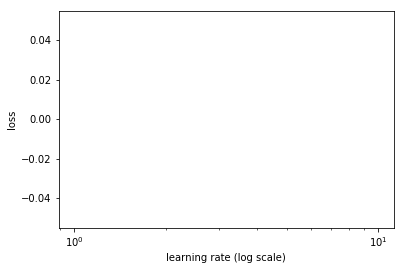

In [72]:
m.sched.plot(100)

In [73]:
m.fit(lr, 1, metrics=[rmse])

HBox(children=(IntProgress(value=0, description='Epoch', max=1), HTML(value='')))

  0%|          | 0/4618 [00:00<?, ?it/s]                   


Exception in thread Thread-4:
Traceback (most recent call last):
  File "/home/eric/anaconda3/envs/fastai/lib/python3.6/threading.py", line 916, in _bootstrap_inner
    self.run()
  File "/home/eric/anaconda3/envs/fastai/lib/python3.6/site-packages/tqdm/_tqdm.py", line 144, in run
    for instance in self.tqdm_cls._instances:
  File "/home/eric/anaconda3/envs/fastai/lib/python3.6/_weakrefset.py", line 60, in __iter__
    for itemref in self.data:
RuntimeError: Set changed size during iteration



[  0.  nan  nan  nan]                                            



In [ ]:
m.fit(lr, 3, metrics=[rmse])